In [1]:
%load_ext autoreload
%autoreload 2

versions:
    
    * sklearn==0.20.0
    
    * xgboost==0.90

In [231]:
import sys
sys.path.insert(0, '/opt/workspace/libs/')
import sys
import pandas as pd
import joblib
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, \
                            classification_report, precision_score, \
                            recall_score, roc_curve, precision_recall_curve, \
                            average_precision_score, make_scorer, confusion_matrix
import numpy as np
import gc
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/home/patrakova1-es_ca-sbrf-ru/notebooks/ds/visualization/')
from plot import Plot

%matplotlib inline

In [232]:
import warnings
warnings.filterwarnings('ignore')

Загрузка датасета

In [233]:
df=pd.read_csv("/tmp/_patrakova/overall_65m_10_2019.csv", sep=';')

In [235]:
desc=df.describe().T

In [236]:
df.shape

(69602429, 93)

In [237]:
df = df[df['responce']!='responce']

In [238]:
df = df.dropna(subset=['responce'])

In [239]:
df.responce = df.responce.astype(int)

Оставляем только те записи у которых первый уровень окпд совпадает

In [240]:
df=df[df['okpd_number1_in_list']==1]
df.shape

(65149218, 93)

In [11]:
df.responce.value_counts(normalize=True)

0    0.903275
1    0.096725
Name: responce, dtype: float64

In [12]:
df.responce.value_counts()

0    58847651
1     6301567
Name: responce, dtype: int64

In [241]:
df['month_year']=df.calculation_date.apply(lambda x: x[:-3])

In [242]:
train_month=['2018-07',
 '2018-08',
 '2018-09',
 '2018-10',
 '2018-11',
 '2018-12',
 '2019-01',
 '2019-02',
 '2019-03',
 '2019-04',
 '2019-05'
]
test_month=['2019-06',
 '2019-07',
 '2019-08']

In [243]:
df=df[df.month_year.isin([   '2018-07',
                             '2018-08',
                             '2018-09',
                             '2018-10',
                             '2018-11',
                             '2018-12',
                             '2019-01',
                             '2019-02',
                             '2019-03',
                             '2019-04',
                             '2019-05',
                             '2019-06',
                             '2019-07',
                             '2019-08'
                            ])]

In [16]:
df.shape

(60703642, 94)

## Проверка на пропуски и константные колонки

In [18]:
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

In [31]:
nulls=df.isnull().sum(axis=0)

In [32]:
nulls=nulls/df.shape[0]

In [33]:
nulls.head(100)

t_initial_price                      0.522802
date_diff                            0.000000
days_last_win                        0.016595
days_last_participate                0.000000
last_initial_price_3m                0.520450
last_initial_price                   0.471906
win_cnt_current_year                 0.152856
participate_cnt_current_year         0.078863
win_cnt_1m                           0.378100
participate_cnt_1m                   0.228292
participate_cnt_3m                   0.077286
win_cnt_3m                           0.168893
win_cnt_6m                           0.063752
participate_cnt_6m                   0.016775
win_cnt_12m                          0.018328
participate_cnt_12m                  0.000004
win_overall                          0.016595
participate_overall                  0.000000
participation_lly                    0.219965
participation_ly                     0.089345
max_offer_ly                         0.463419
max_offer_lly                     

In [34]:
nulls[nulls>0.70]

sum_tenders_lly                     0.784174
sum_tenders_ly                      0.755771
sum_contracts_lly                   0.921912
sum_contracts_ly                    0.924455
revenue_1                           1.000000
revenue_2                           1.000000
cur_customer_last_win_3m            0.778097
cur_customer_last_win_1m            0.906171
cur_customer_last_participate_1m    0.823393
cur_customer_last_win_3m_ratio      0.778097
cur_customer_last_win_1m_ratio      0.906171
dtype: float64

Признаки revenue_1 и revenue_2 исключены

In [244]:
features=['t_initial_price', 'date_diff', 'days_last_win',
       'days_last_participate', 'last_initial_price_3m', 'last_initial_price',
       'win_cnt_current_year', 'participate_cnt_current_year', 'win_cnt_1m',
       'participate_cnt_1m', 'participate_cnt_3m', 'win_cnt_3m', 'win_cnt_6m',
       'participate_cnt_6m', 'win_cnt_12m', 'participate_cnt_12m',
       'win_overall', 'participate_overall', 'participation_lly',
       'participation_ly', 'max_offer_ly', 'max_offer_lly', 'number_wins_lly',
       'number_wins_ly', 'sum_tenders_lly', 'sum_tenders_ly',
       'sum_tenders_current_year', 'number_contracts_lly',
       'number_contracts_ly', 'sum_contracts_lly', 'sum_contracts_ly',
       'avg_ensure_value_12m', 'avg_ensure_value_6m',
       'avg_ensure_value_3m', 'max_ensure_value_12m', 'max_ensure_value_6m',
       'max_ensure_value_3m', 'min_ensure_value_12m', 'min_ensure_value_6m',
       'min_ensure_value_3m', 'avg_ensure_sum_12m', 'avg_ensure_sum_6m',
       'avg_ensure_sum_3m', 'max_ensure_sum_12m', 'max_ensure_sum_6m',
       'max_ensure_sum_3m', 'min_ensure_sum_12m', 'min_ensure_sum_6m',
       'min_ensure_sum_3m', 'avg_initial_price_12m', 'avg_initial_price_6m',
       'avg_initial_price_3m', 'max_initial_price_12m', 'max_initial_price_6m',
       'max_initial_price_3m', 'min_initial_price_12m', 'min_initial_price_6m',
       'min_initial_price_3m', 'other_regions_tenders', 'other_city_tenders',
       'revenue', 'cur_customer_last_win_12m',
       'cur_customer_last_participate_12m', 'cur_customer_last_win_6m',
       'cur_customer_last_participate_6m', 'cur_customer_last_win_3m',
       'cur_customer_last_participate_3m', 'cur_customer_last_win_1m',
       'cur_customer_last_participate_1m', 'cur_customer_win_overall',
       'cur_customer_participate_overall', 'cur_customer_last_win_12m_ratio',
       'cur_customer_last_win_6m_ratio', 'cur_customer_last_win_3m_ratio',
       'cur_customer_last_win_1m_ratio', 'cur_customer_overall_win_ratio',
       'region_in_list', 'okpd_letter_in_list',
       'okpd_number2_in_list', 'okpd_number3_in_list', 'okpd_number4_in_list',
       'federal_in_list', 'region_in_popular', 'city_in_popular', 'revenue_initial_price']

target_col='responce'
target_win='winner_flg'

In [245]:
df[features]=df[features].astype(float)

In [22]:
df.shape

(60703642, 94)

In [246]:
df=df.drop_duplicates(subset=df.columns[1:])

In [24]:
df.shape

(54797502, 94)

### Разбивка на train и test по месяцам

In [30]:
X_train, y_train = df[df.month_year.isin(train_month)][features], df[df.month_year.isin(train_month)]['responce'] 
X_test, y_test = df[df.month_year.isin(test_month)][features], df[df.month_year.isin(test_month)]['responce'] 

In [31]:
del df

gc.collect()

28

In [26]:
y_train.value_counts(normalize=True)

0    0.914316
1    0.085684
Name: responce, dtype: float64

In [27]:
y_test.value_counts(normalize=True)

0    0.917968
1    0.082032
Name: responce, dtype: float64

In [24]:
X_train.to_csv('/tmp/_patrakova/x_train.csv', sep=';')
X_test.to_csv('/tmp/_patrakova/x_test.csv', sep=';')
y_train.to_csv('/tmp/_patrakova/y_train.csv', sep=';')
y_test.to_csv('/tmp/_patrakova/y_test.csv', sep=';')

### Подбор модели

In [32]:
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier, plot_metric
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [33]:
classifiers = {
    'DecisionTreeClassifier': DecisionTreeClassifier(max_depth=8, random_state=42),
    'RandomForestClassifier': RandomForestClassifier(max_depth=8,  n_jobs=80,  class_weight='balanced', random_state=42),
    'LogisticRegression': LogisticRegression(class_weight='balanced', random_state=42),
    'XGBClassifier': XGBClassifier(scale_pos_weight=1.7, seed=42, n_jobs=80),
    'LGBMClassifier': LGBMClassifier(n_estimators=100, silent=False, ntrhred=80, random_state=42, class_weight=True)
}

In [34]:
def get_metrics(model, X, y):
    y_pred = model.predict(X)
    print(classification_report(y, y_pred, digits=5))
    accuracy=model.score(X, y)
    recall = recall_score(y, y_pred)
    precision=precision_score(y, y_pred)
    f1=f1_score(y, y_pred)
    
    return accuracy, recall, precision, f1

def train_test_models(X_train, X_test, y_train,  y_test):
    metrics=pd.DataFrame()

    for name, model in classifiers.items():
        print(name)
        if name in ['DecisionTreeClassifier', 'RandomForestClassifier', 'AdaBoostClassifier', 'QuadraticDiscriminantAnalysis', 'LogisticRegression']:
            X_train=X_train.fillna(0)
            X_test=X_test.fillna(0)
        model.fit(X_train, y_train)
        tr=model.score(X_train, y_train)

        #метрики на тестовой с исходным балансом классов
        ts, recall_ts, precision_ts, f1_ts =  get_metrics(model, X_test, y_test)

        metrics=metrics.append([[name, tr,  ts,  precision_ts, recall_ts, f1_ts]])
        print('На отложенной тестовой выборке: ')
        print('Precision: %7.5f, Recall: %7.5f, F_мера: %7.5f,  Test accuracy: %7.5f, ' % 
           (precision_ts, recall_ts, f1_ts, ts))
        
    return metrics

In [33]:
metrics=train_test_models(X_train, X_test, y_train,  y_test)
metrics.columns=['model', 'accuracy_train', 'accuracy_test',  'precision_test', 'recall_test', 'f-мера_test']      
metrics.to_excel('metrics.xlsx', encoding='cp1251')

RandomForestClassifier


/opt/cloudera/parcels/PYENV.ZNO0059623792/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0    0.97508   0.78543   0.87004   8321083
           1    0.24409   0.77534   0.37129    743594

   micro avg    0.78460   0.78460   0.78460   9064677
   macro avg    0.60958   0.78038   0.62066   9064677
weighted avg    0.91511   0.78460   0.82912   9064677

На отложенной тестовой выборке: 
Precision: 0.24409, Recall: 0.77534, F_мера: 0.37129,  Test accuracy: 0.78460, 
XGBClassifier
[14:21:21] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
              precision    recall  f1-score   support

           0    0.94825   0.97503   0.96145   8321083
           1    0.59148   0.40450   0.48043    743594

   micro avg    0.92823   0.92823   0.92823   9064677
   macro avg    0.76986   0.68977   0.72094   9064677
weighted avg    0.91898   0.92823   0.92199   9064677

На от

/opt/cloudera/parcels/PYENV.ZNO0059623792/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0    0.92363   0.63701   0.75400   8321083
           1    0.09180   0.41057   0.15005    743594

   micro avg    0.61843   0.61843   0.61843   9064677
   macro avg    0.50771   0.52379   0.45202   9064677
weighted avg    0.85539   0.61843   0.70446   9064677

На отложенной тестовой выборке: 
Precision: 0.09180, Recall: 0.41057, F_мера: 0.15005,  Test accuracy: 0.61843, 
LGBMClassifier
              precision    recall  f1-score   support

           0    0.93989   0.98728   0.96300   8321083
           1    0.67336   0.29345   0.40876    743594

   micro avg    0.93036   0.93036   0.93036   9064677
   macro avg    0.80663   0.64036   0.68588   9064677
weighted avg    0.91803   0.93036   0.91754   9064677

На отложенной тестовой выборке: 
Precision: 0.67336, Recall: 0.29345, F_мера: 0.40876,  Test accuracy: 0.93036, 
DecisionTreeClassifier
              precision    recall  f1-score   support

           0    0.93915   0

In [40]:
metrics

,model,accuracy_train,accuracy_test,precision_test,recall_test,f-мера_test
0,RandomForestClassifier,0.801132,0.784600,0.244088,0.775340,0.371288
0,XGBClassifier,0.920757,0.928232,0.591476,0.404496,0.480435
0,LogisticRegression,0.666614,0.618434,0.091798,0.410575,0.150048
0,LGBMClassifier,0.925729,0.930363,0.673363,0.293448,0.408760
0,DecisionTreeClassifier,0.923731,0.928515,0.645570,0.285107,0.395533


## Отбор модели с 25 признаками

In [35]:
features_selected=open('done+participants_features.txt', 'r').read().split('\n')
len(features_selected)

25

In [36]:
metrics_25=train_test_models(X_train[features_selected], X_test[features_selected], y_train,  y_test)
metrics_25.columns=['model', 'accuracy_train', 'accuracy_test',  'precision_test', 'recall_test', 'f-мера_test']      
metrics_25.to_excel('metrics_25.xlsx', encoding='cp1251')
metrics_25

RandomForestClassifier
              precision    recall  f1-score   support

           0    0.97874   0.76743   0.86030   8321083
           1    0.23813   0.81343   0.36841    743594

   micro avg    0.77121   0.77121   0.77121   9064677
   macro avg    0.60843   0.79043   0.61435   9064677
weighted avg    0.91798   0.77121   0.81995   9064677

На отложенной тестовой выборке: 
Precision: 0.23813, Recall: 0.81343, F_мера: 0.36841,  Test accuracy: 0.77121, 
LogisticRegression
              precision    recall  f1-score   support

           0    0.92084   0.78454   0.84724   8321083
           1    0.09232   0.24524   0.13415    743594

   micro avg    0.74030   0.74030   0.74030   9064677
   macro avg    0.50658   0.51489   0.49069   9064677
weighted avg    0.85287   0.74030   0.78874   9064677

На отложенной тестовой выборке: 
Precision: 0.09232, Recall: 0.24524, F_мера: 0.13415,  Test accuracy: 0.74030, 
XGBClassifier
[15:51:18] WARNING: /workspace/src/learner.cc:686: Tree method i

,model,accuracy_train,accuracy_test,precision_test,recall_test,f-мера_test
0,RandomForestClassifier,0.774700,0.771207,0.238128,0.813428,0.368406
0,LogisticRegression,0.731074,0.740296,0.092322,0.245241,0.134145
0,XGBClassifier,0.920537,0.928137,0.591970,0.398944,0.476656
0,LGBMClassifier,0.924955,0.929890,0.660002,0.299750,0.412264
0,DecisionTreeClassifier,0.923553,0.929055,0.635535,0.316865,0.422887


### Отбор признаков

In [47]:
def get_metrics(y_pred, y):
    print(classification_report(y, y_pred, digits=5, ))
    recall = recall_score(y, y_pred)
    precision=precision_score(y, y_pred)
    f1=f1_score(y, y_pred)
    
    return recall, precision, f1

In [34]:
sys.path.insert(0, '/home/patrakova1-es_ca-sbrf-ru/notebooks/')

from ds.feature_engineering.forward_permutation_feature_selection_cv import ForwardPermutationFeatureSelectionCV
from ds.feature_engineering.forward_permutation_feature_selection import ForwardPermutationFeatureSelection
from ds.feature_engineering.feature_importance import FeatureImportance
from sklearn.preprocessing import binarize

In [35]:
X_train_per, X_test_per, y_train_per, y_test_per=train_test_split(X_train, y_train, train_size=0.7, random_state=42, stratify=y_train)

/opt/cloudera/parcels/PYENV.ZNO0059623792/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [42]:
y_train_per.value_counts(normalize=True)

0    0.914316
1    0.085684
Name: responce, dtype: float64

In [43]:
y_test_per.value_counts(normalize=True)

0    0.914316
1    0.085684
Name: responce, dtype: float64

In [48]:
model=XGBClassifier(scale_pos_weight=1.7, seed=42, n_jobs=100)

In [49]:
model.fit(X_train_per, y_train_per)

pred_xgboost_model=model.predict_proba(X_test_per.astype(float))[:,1]
pred = binarize(pred_xgboost_model.reshape(-1,1), threshold=0.5).reshape(-1)
recall_ts, precision_ts, f1_ts =  get_metrics(pred.astype(int), y_test_per.astype(int))
                                                  
print('На отложенной тестовой выборке: ')
print('Precision: %7.5f, Recall: %7.5f, F_мера: %7.5f' % 
(precision_ts, recall_ts, f1_ts))

[07:05:19] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
              precision    recall  f1-score   support

           0    0.94389   0.97109   0.95730  12544275
           1    0.55454   0.38403   0.45380   1175573

   micro avg    0.92079   0.92079   0.92079  13719848
   macro avg    0.74922   0.67756   0.70555  13719848
weighted avg    0.91053   0.92079   0.91416  13719848

На отложенной тестовой выборке: 
Precision: 0.55454, Recall: 0.38403, F_мера: 0.45380


In [46]:
imp=FeatureImportance(X_train_per, X_test_per, y_train_per, y_test_per, model, metric='f1')

In [50]:
selected_features=imp.get_n_permutation_importance(model=model, n_jobs=1)

AUC:0.87423, Precision:0.55454, Recall:0.38403, True:451459 of 814109, Total:1175573, Tr:0.50
AUC:0.87296, Precision:0.55434, Recall:0.37986, True:446551 of 805556, Total:1175573, Tr:0.50
AUC:0.87297, Precision:0.55446, Recall:0.37999, True:446706 of 805662, Total:1175573, Tr:0.50
AUC:0.87233, Precision:0.55272, Recall:0.37751, True:443788 of 802915, Total:1175573, Tr:0.50
AUC:0.87233, Precision:0.55281, Recall:0.37756, True:443854 of 802902, Total:1175573, Tr:0.50
AUC:0.87423, Precision:0.55454, Recall:0.38403, True:451459 of 814109, Total:1175573, Tr:0.50
AUC:0.87423, Precision:0.55454, Recall:0.38403, True:451459 of 814109, Total:1175573, Tr:0.50
AUC:0.87220, Precision:0.55677, Recall:0.37914, True:445710 of 800523, Total:1175573, Tr:0.50
AUC:0.87222, Precision:0.55667, Recall:0.37922, True:445801 of 800830, Total:1175573, Tr:0.50
AUC:0.87420, Precision:0.55453, Recall:0.38394, True:451351 of 813928, Total:1175573, Tr:0.50
AUC:0.87420, Precision:0.55452, Recall:0.38395, True:451359 

AUC:0.87414, Precision:0.55376, Recall:0.38372, True:451087 of 814585, Total:1175573, Tr:0.50
AUC:0.87420, Precision:0.55450, Recall:0.38322, True:450504 of 812448, Total:1175573, Tr:0.50
AUC:0.87420, Precision:0.55450, Recall:0.38323, True:450515 of 812469, Total:1175573, Tr:0.50
AUC:0.87423, Precision:0.55454, Recall:0.38403, True:451459 of 814109, Total:1175573, Tr:0.50
AUC:0.87423, Precision:0.55454, Recall:0.38403, True:451459 of 814109, Total:1175573, Tr:0.50
AUC:0.87424, Precision:0.55461, Recall:0.38319, True:450465 of 812224, Total:1175573, Tr:0.50
AUC:0.87424, Precision:0.55467, Recall:0.38320, True:450485 of 812169, Total:1175573, Tr:0.50
AUC:0.87425, Precision:0.55483, Recall:0.38318, True:450456 of 811879, Total:1175573, Tr:0.50
AUC:0.87426, Precision:0.55484, Recall:0.38319, True:450466 of 811882, Total:1175573, Tr:0.50
AUC:0.87403, Precision:0.55542, Recall:0.38073, True:447571 of 805824, Total:1175573, Tr:0.50
AUC:0.87402, Precision:0.55555, Recall:0.38078, True:447631 

In [51]:
selected_features.sort_values(by='permutation_f1', ascending=False).head(30)

,features,permutation_f1
0,cur_customer_participate_overall,0.326707
0,okpd_number4_in_list,0.066748
0,okpd_number3_in_list,0.036274
0,okpd_number2_in_list,0.014461
0,date_diff,0.005187
0,region_in_popular,0.004967
0,revenue,0.004467
0,min_initial_price_3m,0.004123
0,avg_initial_price_12m,0.003910
0,participate_cnt_6m,0.003639


In [64]:
selected_features.sort_values(by='permutation_f1', ascending=False).to_excel('imp_permutation.xlsx')

## 30 отобранных признаков

In [52]:
features_selected=selected_features.sort_values(by='permutation_f1', ascending=False)['features'].tolist()[:30]

In [53]:
model=XGBClassifier(nthread=100, seed=42, scale_pos_weight=1.7)

In [54]:
model.fit(X_train[features_selected].astype(float), y_train)

[14:08:26] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=100,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1.7, seed=42, silent=None,
       subsample=1, verbosity=1)

In [56]:
pred_xgboost_model=model.predict_proba(X_test[features_selected].astype(float))[:,1]

In [60]:
p=Plot()

Cross point:  34


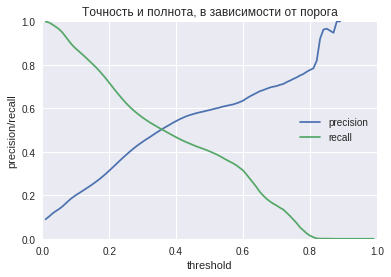

In [81]:
p.precision_recall_threshold_curve(y_test, pred_xgboost_model)

In [58]:
pred = binarize(pred_xgboost_model.reshape(-1,1), threshold=0.5).reshape(-1)

In [59]:
recall_ts, precision_ts, f1_ts =  get_metrics(pred.astype(int), y_test.astype(int))
                                                  
print('На отложенной тестовой выборке: ')
print('Precision: %7.5f, Recall: %7.5f, F_мера: %7.5f' % 
(precision_ts, recall_ts, f1_ts))

              precision    recall  f1-score   support

           0    0.94808   0.97523   0.96146   8321083
           1    0.59209   0.40238   0.47914    743594

   micro avg    0.92824   0.92824   0.92824   9064677
   macro avg    0.77009   0.68881   0.72030   9064677
weighted avg    0.91888   0.92824   0.92190   9064677

На отложенной тестовой выборке: 
Precision: 0.59209, Recall: 0.40238, F_мера: 0.47914


## 25 отобранных признаков

In [82]:
features_selected=selected_features.sort_values(by='permutation_f1', ascending=False)['features'].tolist()[:25]

In [123]:
model=XGBClassifier(nthread=100, seed=42, scale_pos_weight=1.7)
model.fit(X_train[features_selected].astype(float), y_train)
pred_xgboost_model=model.predict_proba(X_test[features_selected].astype(float))[:,1]

[11:19:16] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


Cross point:  34


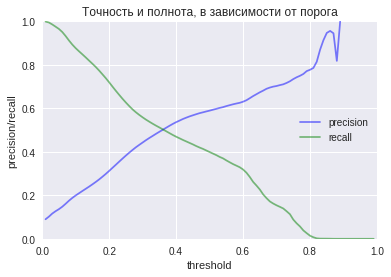

In [148]:
p.precision_recall_threshold_curve(y_test, pred_xgboost_model)

In [149]:
pred = binarize(pred_xgboost_model.reshape(-1,1), threshold=0.5).reshape(-1)

In [150]:
recall_ts, precision_ts, f1_ts =  get_metrics(pred.astype(int), y_test.astype(int))
                                                  
print('На отложенной тестовой выборке: ')
print('Precision: %7.5f, Recall: %7.5f, F_мера: %7.5f' % 
(precision_ts, recall_ts, f1_ts))

              precision    recall  f1-score   support

           0    0.94781   0.97516   0.96129   8321083
           1    0.58942   0.39910   0.47594    743594

   micro avg    0.92790   0.92790   0.92790   9064677
   macro avg    0.76861   0.68713   0.71861   9064677
weighted avg    0.91841   0.92790   0.92147   9064677

На отложенной тестовой выборке: 
Precision: 0.58942, Recall: 0.39910, F_мера: 0.47594


In [87]:
open('done+participants_features.txt', 'w').write('\n'.join(features_selected))

523

In [151]:
import seaborn as sns

In [172]:
imp=pd.DataFrame([model.get_booster().get_score(importance_type='gain')]).T.reset_index()
imp=imp.sort_values(0, ascending=False).head(50)
plt.figure(figsize=(10,10))
imp.columns=['features', 'importance']

In [177]:
features_dict=pd.read_excel('features_dict.xlsx', header=None)

In [181]:
imp['names']=imp['features'].apply(lambda x: features_dict[features_dict[0]==x][1].values[0])

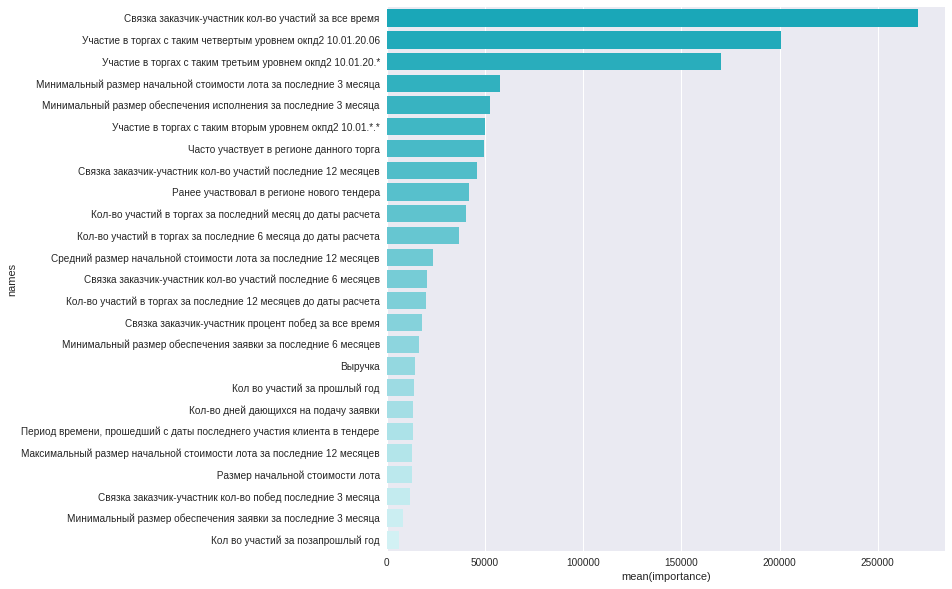

In [184]:
plt.figure(figsize=(10,10))
sns.set_palette(sns.light_palette((210,100,70), input='husl', n_colors=28, reverse=True))
sns.barplot(x=imp['importance'], y=imp['names'])

## Подбор гиперпараметров

In [37]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, GridSearchCV

In [38]:
skf=StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [ ]:
X_train_per, X_test_per, y_train_per, y_test_per=train_test_split(X_train, y_train, train_size=0.7, random_state=42, stratify=y_train)

In [ ]:
xgb = XGBClassifier(seed = 42, nthread=-1)
params = {
    'gamma': [0, 0.5, 1, 1.5, 2, 3],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'scale_pos_weight': [1.5, 2.5, 3, 5, 10]
}

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=20, scoring='f1', n_jobs=1, 
                                   cv=skf.split(X_train_per[features_selected].astype(float), y_train_per), verbose=3, random_state=42)
random_search.fit(X_train_per[features_selected].astype(float), y_train_per)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] max_depth=7, scale_pos_weight=10, gamma=0 .......................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[17:07:45] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[CV]  max_depth=7, scale_pos_weight=10, gamma=0, score=0.4113681877503263, total=34.9min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 35.3min remaining:    0.0s


[CV] max_depth=7, scale_pos_weight=10, gamma=0 .......................
[17:43:04] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[CV]  max_depth=7, scale_pos_weight=10, gamma=0, score=0.4127861412394994, total=32.7min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 68.3min remaining:    0.0s


[CV] max_depth=7, scale_pos_weight=10, gamma=0 .......................
[18:16:07] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[CV]  max_depth=7, scale_pos_weight=10, gamma=0, score=0.41236840762334276, total=32.9min
[CV] max_depth=4, scale_pos_weight=2.5, gamma=0 ......................
[18:49:22] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[CV]  max_depth=4, scale_pos_weight=2.5, gamma=0, score=0.4810486598654381, total=23.0min
[CV] max_depth=4, scale_pos_weight=2.5, gamma=0 ......................
[19:12:38] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single mac

## Обучение модели

Тестировались варианты отбора признаков по average_precision, f1 и precision. На лучших обучена модель:

In [207]:
model=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=100, nthread=-1, objective='binary:logistic',
       reg_lambda=1, scale_pos_weight=3,
       seed=42, silent=None, subsample=1, verbosity=1)

In [208]:
model.fit(X_train[features_selected].astype(float), y_train)

[06:48:59] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=-1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=3,
       seed=42, silent=None, subsample=1, verbosity=1)

In [211]:
predictions=model.predict(X_test[features_selected].astype(float))
probs=model.predict_proba(X_test[features_selected].astype(float))[:, 1]

In [212]:
recall_ts, precision_ts, f1_ts =  get_metrics(predictions.astype(int), y_test.astype(int))
                                                  
print('На отложенной тестовой выборке: ')
print('Precision: %7.5f, Recall: %7.5f, F_мера: %7.5f' % 
(precision_ts, recall_ts, f1_ts))

              precision    recall  f1-score   support

           0    0.95622   0.95577   0.95599   8321083
           1    0.50764   0.51030   0.50896    743594

   micro avg    0.91923   0.91923   0.91923   9064677
   macro avg    0.73193   0.73303   0.73248   9064677
weighted avg    0.91942   0.91923   0.91932   9064677

На отложенной тестовой выборке: 
Precision: 0.50764, Recall: 0.51030, F_мера: 0.50896


In [213]:
p=Plot()

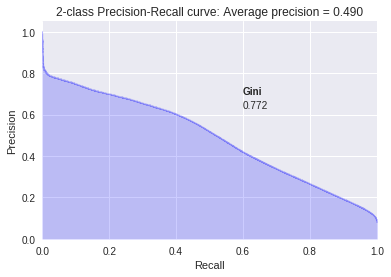

In [214]:
p.precision_recall_curve(y_test, probs)

Cross point:  49


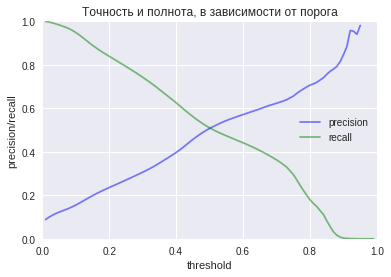

In [217]:
p.precision_recall_threshold_curve(y_test, probs)

In [220]:
joblib.dump(model, 'xgboost_more_data_done.pkl')

['xgboost_more_data_done.pkl']

### Тестирование на каждом месяце

In [247]:
model=joblib.load('xgboost_more_data_done.pkl')

In [248]:
test_month=['2019-06', '2019-07', '2019-08']

In [250]:
for month in test_month:
    X_test, y_test = df[df.month_year==month][features_selected], df[df.month_year==month]['responce'] 
    predictions=model.predict(X_test[features_selected].astype(float))
    probs=model.predict_proba(X_test[features_selected].astype(float))[:, 1]
    recall_ts, precision_ts, f1_ts =  get_metrics(predictions.astype(int), y_test.astype(int))

    print('На отложенной тестовой выборке: ')
    print('Precision: %7.5f, Recall: %7.5f, F_мера: %7.5f' % 
    (precision_ts, recall_ts, f1_ts))

              precision    recall  f1-score   support

           0    0.95382   0.95089   0.95235   2572486
           1    0.49840   0.51452   0.50633    243965

   micro avg    0.91309   0.91309   0.91309   2816451
   macro avg    0.72611   0.73270   0.72934   2816451
weighted avg    0.91437   0.91309   0.91372   2816451

На отложенной тестовой выборке: 
Precision: 0.49840, Recall: 0.51452, F_мера: 0.50633
              precision    recall  f1-score   support

           0    0.95728   0.95652   0.95690   3396312
           1    0.50631   0.51091   0.50860    296394

   micro avg    0.92076   0.92076   0.92076   3692706
   macro avg    0.73180   0.73372   0.73275   3692706
weighted avg    0.92109   0.92076   0.92092   3692706

На отложенной тестовой выборке: 
Precision: 0.50631, Recall: 0.51091, F_мера: 0.50860
              precision    recall  f1-score   support

           0    0.95730   0.96002   0.95866   2352285
           1    0.52151   0.50433   0.51278    203235

   micro a

## Выбор порога вероятности

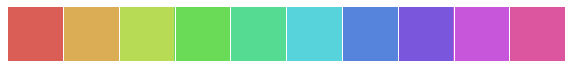

In [223]:
from sklearn.preprocessing import binarize
from matplotlib_venn import venn2
import seaborn as sns
colors=sns.color_palette('hls', 10)
sns.palplot(colors)

0.4
Precision:    0.40, Recall:    0.63, F_мера:    0.49
0.5
Precision:    0.51, Recall:    0.51, F_мера:    0.51
0.6
Precision:    0.57, Recall:    0.44, F_мера:    0.50
0.75
Precision:    0.66, Recall:    0.30, F_мера:    0.41
0.8
Precision:    0.71, Recall:    0.18, F_мера:    0.29


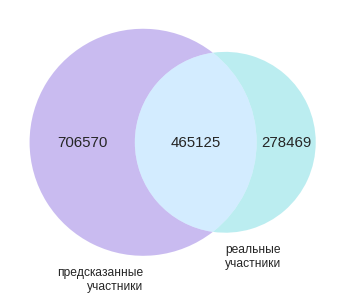

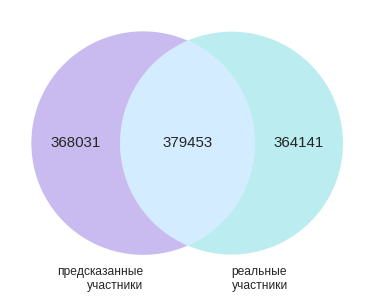

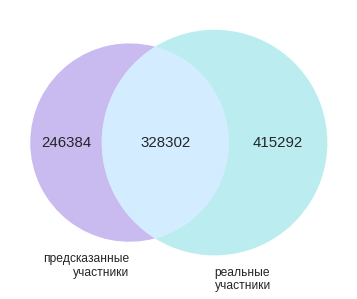

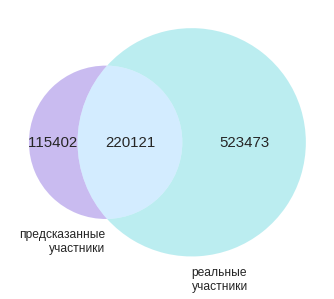

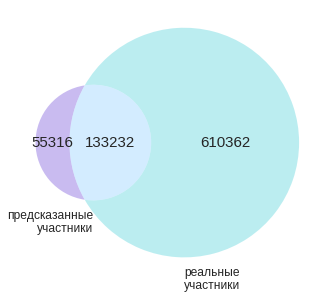

In [230]:
thresholds = [0.4, 0.5, 0.6,  0.75, 0.8]
cnt=1
for t in thresholds:
    pred = binarize(probs.reshape(-1,1), threshold=t).reshape(-1)
    
    recall = recall_score(y_test, pred)
    precision=precision_score(y_test, pred)
    f1=f1_score(y_test, pred)
    print(t)
    print('Precision: %7.2f, Recall: %7.2f, F_мера: %7.2f' % (precision, recall, f1))
    
    preds=pd.DataFrame({'prediction':pred, 'response': y_test})
    predictions=preds[preds.prediction==1].prediction.to_dict().items()
    test=preds[preds.response==1].response.to_dict().items()
    plt.figure(num=cnt, figsize=(8,5))
    cnt+=1
    ven=venn2([set(predictions), set(test)], set_labels=['предсказанные\nучастники', 'реальные\nучастники'], set_colors=[colors[7], colors[5]])
    for text in ven.subset_labels:
        text.set_fontsize(15)